In [1]:
from dataclasses import dataclass
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import make_moons
from tqdm import tqdm, trange

# Model

In [2]:
@dataclass
class VAEOutput:
    """
    Dataclass for VAE output.
    
    Attributes:
        z_dist (torch.distributions.Distribution): The distribution of the latent variable z.
        z_sample (torch.Tensor): The sampled value of the latent variable z.
        x_recon (torch.Tensor): The reconstructed output from the VAE.
        loss (torch.Tensor): The overall loss of the VAE.
        loss_recon (torch.Tensor): The reconstruction loss component of the VAE loss.
        loss_kl (torch.Tensor): The KL divergence component of the VAE loss.
    """
    z_dist: torch.distributions.Distribution
    z_sample: torch.Tensor
    x_dist: torch.distributions.Distribution
    x_recon: torch.Tensor
    
    loss: torch.Tensor
    loss_recon: torch.Tensor
    loss_kl: torch.Tensor


class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) class.
    
    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dim (int | list[int]): Dimensionality of the hidden layers.
        latent_dim (int): Dimensionality of the latent space.
    """
    
    def __init__(self, input_dim: int, hidden_dim: int | list[int], latent_dim: int):
        super(VAE, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        encoder_layers_list = []
        if type(hidden_dim) != list:
            encoder_layers_list.append(nn.Linear(input_dim, hidden_dim))
            encoder_layers_list.append(nn.LeakyReLU())
            encoder_layers_list.append(nn.Linear(hidden_dim, 2 * latent_dim))
        else:
            self.hidden_dim = hidden_dim.copy()
            encoder_layers_list.append(nn.Linear(input_dim, hidden_dim[0]))
            encoder_layers_list.append(nn.LeakyReLU())
            for i in range(len(hidden_dim[1:])):
                encoder_layers_list.append(nn.Linear(hidden_dim[i], hidden_dim[i+1]))
                encoder_layers_list.append(nn.LeakyReLU())
            encoder_layers_list.append(nn.Linear(hidden_dim[-1], 2 * latent_dim))
        
        self.encoder = nn.Sequential(*encoder_layers_list)

        decoder_layers_list = []
        if type(hidden_dim) != list:
            decoder_layers_list.append(nn.Linear(latent_dim, hidden_dim))
            decoder_layers_list.append(nn.LeakyReLU())
            decoder_layers_list.append(nn.Linear(hidden_dim, 2 * input_dim))
        else:
            hidden_dim_decoder = hidden_dim[::-1]
            decoder_layers_list.append(nn.Linear(latent_dim, hidden_dim_decoder[0]))
            decoder_layers_list.append(nn.LeakyReLU())
            for i in range(len(hidden_dim_decoder[1:])):
                decoder_layers_list.append(nn.Linear(hidden_dim_decoder[i], hidden_dim_decoder[i+1]))
                decoder_layers_list.append(nn.LeakyReLU())
            decoder_layers_list.append(nn.Linear(hidden_dim_decoder[-1], 2 * input_dim))

        self.decoder = nn.Sequential(*decoder_layers_list)

        print(f"Encoder: {encoder_layers_list}")
        print(f"Decoder: {decoder_layers_list}")

    def encode(self, x: torch.Tensor, eps: float = 1e-8):
        """
        Encodes the input data into the latent space.
        
        Args:
            x (torch.Tensor): Input data.
            eps (float): Small value to avoid numerical instability.
        
        Returns:
            torch.distributions.MultivariateNormal: Normal distribution of the encoded data.
        """
        params = self.encoder(x)
        means = params[:, :self.latent_dim]
        covs = torch.diag_embed(torch.exp(params[:, self.latent_dim:]) + eps)
        return torch.distributions.MultivariateNormal(means, covariance_matrix=covs)
    
    def reparameterize(self, dist: torch.distributions.Distribution):
        """
        Reparameterizes the encoded data to sample from the latent space.
        
        Args:
            dist (torch.distributions.MultivariateNormal): Normal distribution of the encoded data.
        Returns:
            torch.Tensor: Sampled data from the latent space.
        """
        return dist.rsample()
    
    def decode(self, z: torch.Tensor, eps: float = 1e-8):
        """
        Decodes the data from the latent space into the original input space.
        
        Args:
            z (torch.Tensor): Data in the latent space.
            eps (float): Small value to avoid numerical instability.
        
        Returns:
            torch.distributions.MultivariateNormal: Normal distribution of the decoded data.
        """
        params = self.decoder(z)
        means = params[:, :self.input_dim]
        covs = torch.diag_embed(torch.exp(params[:, self.input_dim:]) + eps)
        return torch.distributions.MultivariateNormal(means, covariance_matrix=covs)
    
    def forward(self, x: torch.Tensor, compute_loss: bool = True):
        """
        Performs a forward pass of the VAE.
        
        Args:
            x (torch.Tensor): Input data.
            compute_loss (bool): Whether to compute the loss or not.
        
        Returns:
            VAEOutput: VAE output dataclass.
        """
        
        z_dist = self.encode(x)
        z = self.reparameterize(z_dist)
        x_dist = self.decode(z)
        recon_x = x_dist.mean
        
        if not compute_loss:
            return VAEOutput(
                z_dist=z_dist,
                z_sample=z,
                x_dist=x_dist,
                x_recon=recon_x,
                loss=None,
                loss_recon=None,
                loss_kl=None,
            )
        
        # Compute loss terms
        x_diff = x - recon_x
        diagonals = torch.diagonal(x_dist.covariance_matrix, dim1=-2, dim2=-1)
        cov_inv = torch.diag_embed(1.0 / diagonals)
        loss_recon = torch.log(torch.prod(diagonals, dim=-1)).mean() / 2
        loss_recon += torch.unsqueeze(x_diff, 1).bmm(cov_inv).bmm(torch.unsqueeze(x_diff, -1)).mean() / 2
        std_normal = torch.distributions.MultivariateNormal(
            torch.zeros_like(z, device=z.device),
            scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),
        )
        loss_kl = torch.distributions.kl.kl_divergence(z_dist, std_normal).mean()
        
        loss = loss_recon + loss_kl
        
        return VAEOutput(
            z_dist=z_dist,
            z_sample=z,
            x_dist=x_dist,
            x_recon=recon_x,
            loss=loss,
            loss_recon=loss_recon,
            loss_kl=loss_kl,
        )
    
    def log_marginal(self, x: torch.Tensor, num_samples: int = 5):
        z_dist = self.encode(x)
        z_mean = z_dist.mean
        std_normal = torch.distributions.MultivariateNormal(
            torch.zeros_like(z_mean, device=z_mean.device),
            scale_tril=torch.eye(z_mean.shape[-1], device=z_mean.device).unsqueeze(0).expand(z_mean.shape[0], -1, -1),
        )
        if num_samples < 2:
            z = z_dist.sample()
            x_dist = self.decode(z)
            log_marg = x_dist.log_prob(x)
            log_marg += std_normal.log_prob(z)
            log_marg -= z_dist.log_prob(z)
            return log_marg.detach().cpu().flatten()
        total_marginal = 0
        for _ in range(num_samples):
            z = z_dist.sample()
            x_dist = self.decode(z)
            sample_marginal = torch.exp(x_dist.log_prob(x))
            sample_marginal *= torch.exp(std_normal.log_prob(z)) / num_samples
            sample_marginal /= torch.exp(z_dist.log_prob(z))
            total_marginal += sample_marginal
        return torch.log(total_marginal.detach().cpu().flatten())


# Data

In [3]:
def gen_train_test_split(train_size: int, test_size: int, noise: float = 0.15):
    X_train, y_train = make_moons(n_samples=train_size, noise=noise, random_state=123)
    X_test, y_test = make_moons(n_samples=test_size, noise=(noise * 1.4), random_state=123)
    return (X_train, y_train), (X_test, y_test)


class MoonsDataset(Dataset):

    def __init__(self, X, y):
        super().__init__()
        self._X = X
        self._y = y
        self.X = torch.from_numpy(self._X).float()
        self.y = torch.from_numpy(self._y.reshape(-1, 1)).float()
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.X.shape[0]

# Training

In [4]:
torch.manual_seed(123)

batch_size = 150
learning_rate = 1e-4
num_epochs = 800
input_dim = 2
latent_dim = 2
hidden_dim = [256, 128, 64]

train_split, test_split = gen_train_test_split(3000, 600)
train_loader = DataLoader(MoonsDataset(*train_split), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(MoonsDataset(*test_split), batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
def train(model: VAE, dataloader: DataLoader, optimizer: torch.optim.Optimizer):
    """
    Trains the model on the given data.
    
    Args:
        model (nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): The data loader.
        optimizer: The optimizer.
    """
    model.train()  # Set the model to training mode
    loss_total = 0.0
    loss_recon = 0.0
    loss_kl = 0.0
    for data, _ in dataloader:
        data = data.to(device)
        optimizer.zero_grad()  # Zero the gradients
        output = model(data, compute_loss=True)  # Forward pass
        loss = output.loss
        loss.backward()
        optimizer.step()  # Update the model parameters
        loss_total += loss.item()
        loss_recon += output.loss_recon.item()
        loss_kl += output.loss_kl.item()
    n_batchs = len(dataloader)
    loss_total /= n_batchs
    loss_recon /= n_batchs
    loss_kl /= n_batchs
    return loss_total, loss_recon, loss_kl

def test(model: VAE, dataloader: DataLoader):
    """
    Tests the model on the given data.
    
    Args:
        model (nn.Module): The model to test.
        dataloader (torch.utils.data.DataLoader): The data loader.
    """
    model.eval()  # Set the model to evaluation mode
    loss_total = 0.0
    loss_recon = 0.0
    loss_kl = 0.0
    with torch.no_grad():
        for data, _ in dataloader:
            data = data.to(device)
            output = model(data, compute_loss=True)  # Forward pass
        loss_total += output.loss.item()
        loss_recon += output.loss_recon.item()
        loss_kl += output.loss_kl.item()
    n_batchs = len(dataloader)
    loss_total /= n_batchs
    loss_recon /= n_batchs
    loss_kl /= n_batchs
    return loss_total, loss_recon, loss_kl

In [6]:
print("Training Variational Autoencoder...")
model_VAE = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
print(model_VAE)

optimizer = torch.optim.AdamW(model_VAE.parameters(), lr=learning_rate)

train_loss_history = []
test_loss_history = []
for epoch in trange(1, num_epochs + 1, desc='Training', unit='epoch'):
    train_loss = train(model_VAE, train_loader, optimizer)
    test_loss = test(model_VAE, test_loader)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)

Training Variational Autoencoder...
Encoder: [Linear(in_features=2, out_features=256, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=256, out_features=128, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=128, out_features=64, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=64, out_features=4, bias=True)]
Decoder: [Linear(in_features=2, out_features=64, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=64, out_features=128, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=128, out_features=256, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=256, out_features=4, bias=True)]
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): LeakyReLU(negative_slope=0.01)

Training: 100%|██████████| 800/800 [02:50<00:00,  4.70epoch/s]


# Plots

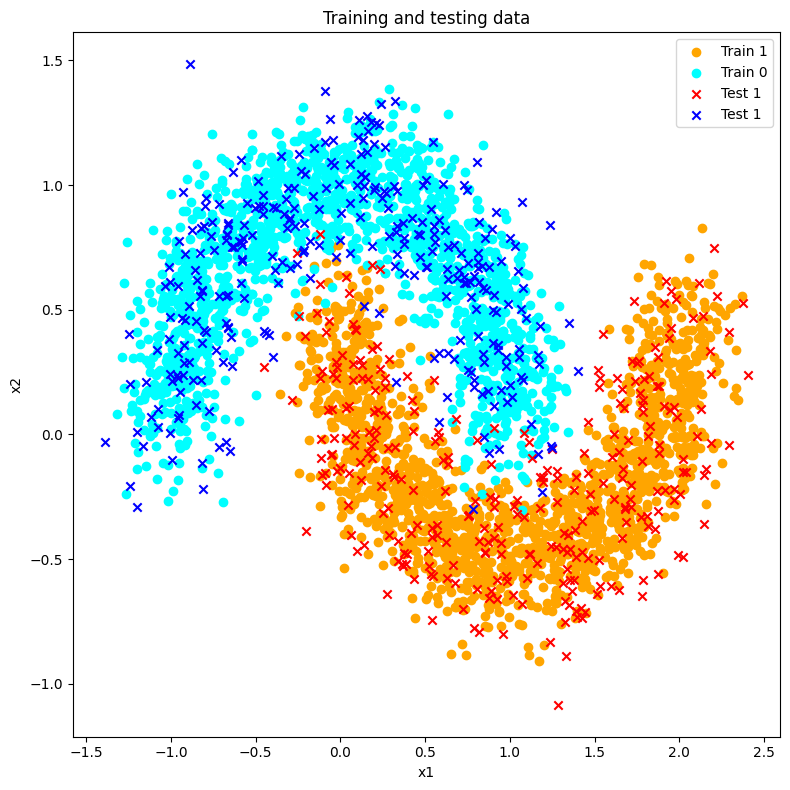

In [7]:
fig = plt.figure(figsize=(8, 8))
# Train data
cls_mask = train_split[1].astype(bool)
plt.scatter(train_split[0][cls_mask, 0], train_split[0][cls_mask, 1], color='orange', label='Train 1')
plt.scatter(train_split[0][~cls_mask, 0], train_split[0][~cls_mask, 1], color='cyan', label='Train 0')
# Test data
cls_mask = test_split[1].astype(bool)
plt.scatter(test_split[0][cls_mask, 0], test_split[0][cls_mask, 1], color='red', marker='x', label='Test 1')
plt.scatter(test_split[0][~cls_mask, 0], test_split[0][~cls_mask, 1], color='blue', marker='x', label='Test 1')

plt.title('Training and testing data')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.tight_layout()
plt.show()

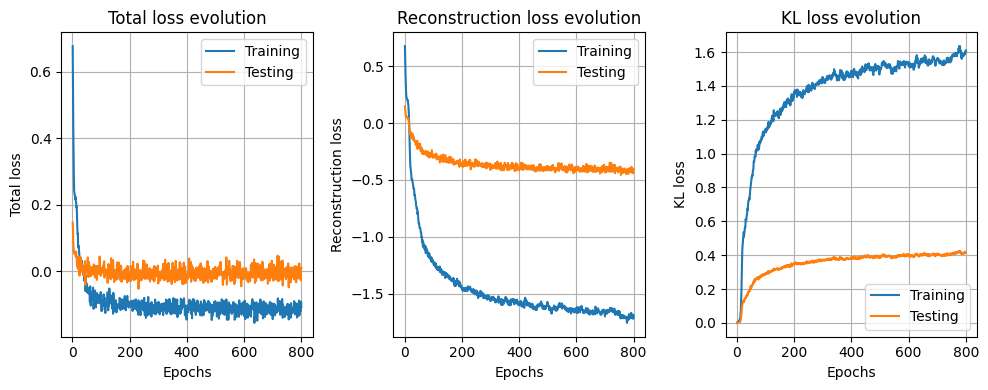

In [8]:
losses_label = ('Total', 'Reconstruction', 'KL')

fig, axs = plt.subplots(1, 3, figsize=(10, 4))

for i, loss_label in enumerate(losses_label):
    ax = axs[i]
    ax.plot(
        range(1, len(train_loss_history) + 1),
        [l[i] for l in train_loss_history],
        label='Training',
    )
    ax.plot(
        range(1, len(test_loss_history) + 1),
        [l[i] for l in test_loss_history],
        label='Testing',
    )
    ax.set_xlabel('Epochs')
    ax.set_ylabel(f'{loss_label} loss')
    ax.set_title(f'{loss_label} loss evolution')
    ax.grid()
    ax.legend()

plt.tight_layout()
plt.show()

In [9]:
def plot_latent_space(model: VAE):
    model.eval()
    z_all = []
    y_all = []
    with torch.no_grad():
        for data, target in tqdm(train_loader, desc='Encoding', unit='batch'):
            z = model.encode(data.to(device))
            z = z.mean
            z_all.append(z.detach().cpu().numpy())
            y_all.append(target.numpy())
    z_all = np.concatenate(z_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)
    cls_mask = y_all.astype(bool).flatten()
    plt.figure(figsize=(10, 10))
    plt.scatter(z_all[cls_mask, 0], z_all[cls_mask, 1], color='red')
    plt.scatter(z_all[~cls_mask, 0], z_all[~cls_mask, 1], color='blue')
    plt.title(f'Latent projection')
    plt.show()


def plot_random_samples(model: VAE, num_samples: int = 200):
    model.eval()
    std_normal = torch.distributions.MultivariateNormal(
        torch.zeros(model.latent_dim, device=device),
        covariance_matrix=torch.eye(model.latent_dim, device=device),
    )
    x_dist = model.decode(std_normal.sample((num_samples,)))
    samples = x_dist.sample().cpu()
    plt.figure(figsize=(10, 10))
    plt.scatter(samples[:, 0], samples[:, 1])
    plt.title('Generated samples')
    plt.show()


def plot_log_marginal(model: VAE, num_samples: int = 5):
    data = train_split[0]
    xmin, ymin = np.floor(data.min(axis=0))
    xmax, ymax = np.ceil(data.max(axis=0))
    xs = np.linspace(xmin, xmax, num=200)
    ys = np.linspace(ymin, ymax, num=200)
    xx, yy = np.meshgrid(xs, ys)
    X = np.column_stack((xx.ravel(), yy.ravel()))
    X = torch.from_numpy(X).float().to(device)
    log_probs = model.log_marginal(X, num_samples)
    log_probs = log_probs.numpy().reshape((xs.size, ys.size))
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    img = ax.imshow(
        log_probs,
        cmap='magma',
        extent=[xmin, xmax, ymin, ymax],
        origin='lower',
        aspect='auto',
        interpolation='nearest',
    )
    fig.colorbar(img, ax=ax, label='Log-verossimilhança')
    cls_mask = train_split[1].astype(bool)
    pos_points = data[cls_mask]
    neg_points = data[~cls_mask]
    ax.scatter(pos_points[::10, 0], pos_points[::10, 1], color='red', alpha=0.5)
    ax.scatter(neg_points[::10, 0], neg_points[::10, 1], color='blue', alpha=0.5)
    ax.set_title('Log-verossimilhança aproximada')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    plt.tight_layout()
    plt.show()

Encoding: 100%|██████████| 20/20 [00:00<00:00, 481.24batch/s]


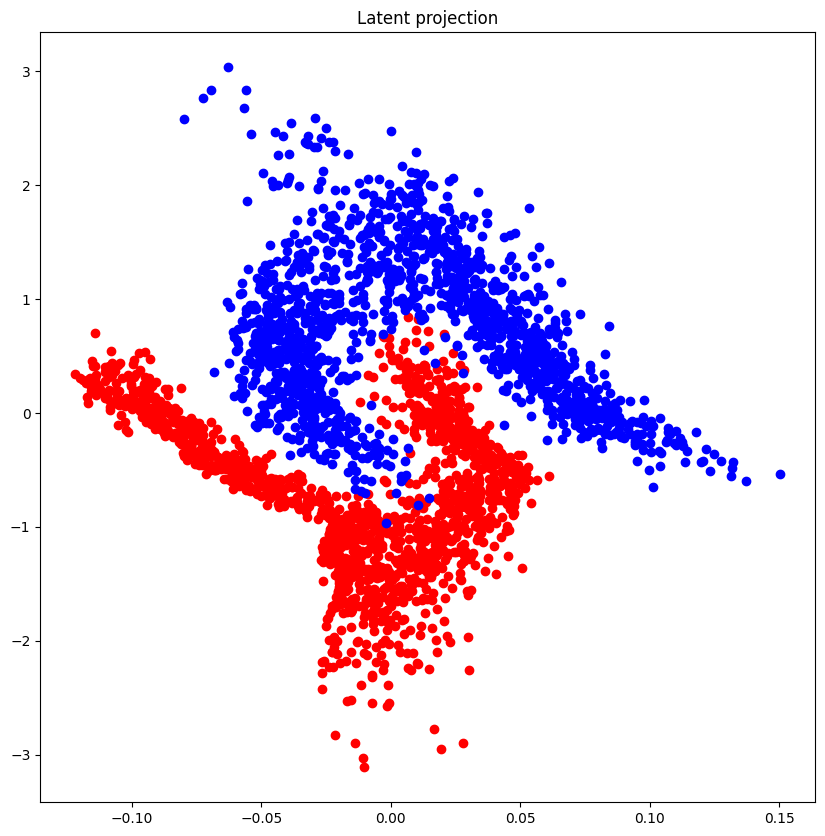

In [10]:
plot_latent_space(model_VAE)

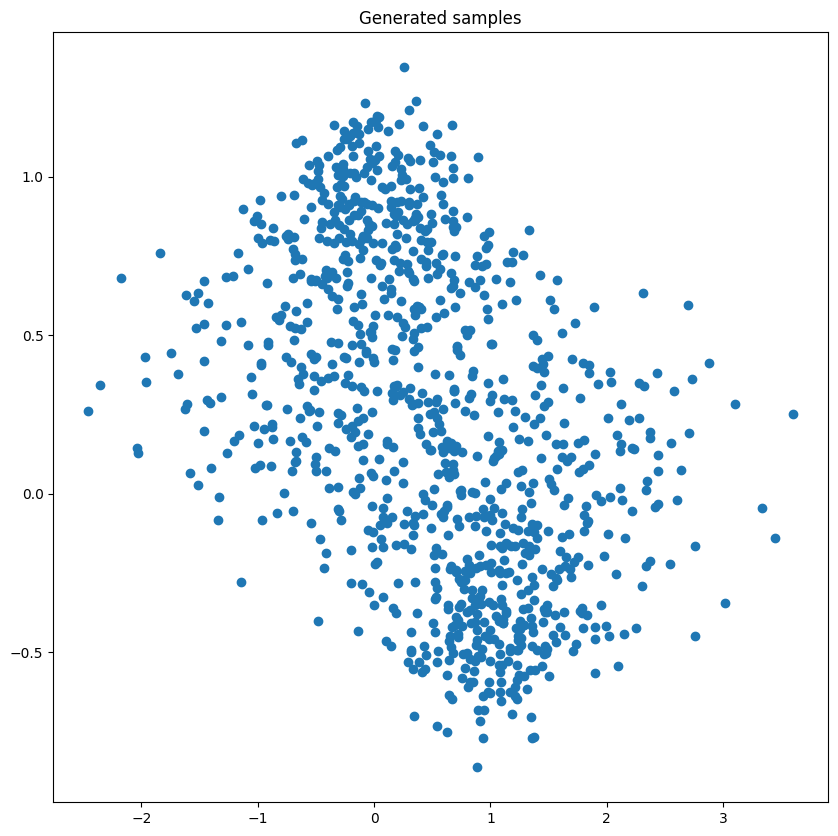

In [11]:
plot_random_samples(model_VAE, 1000)

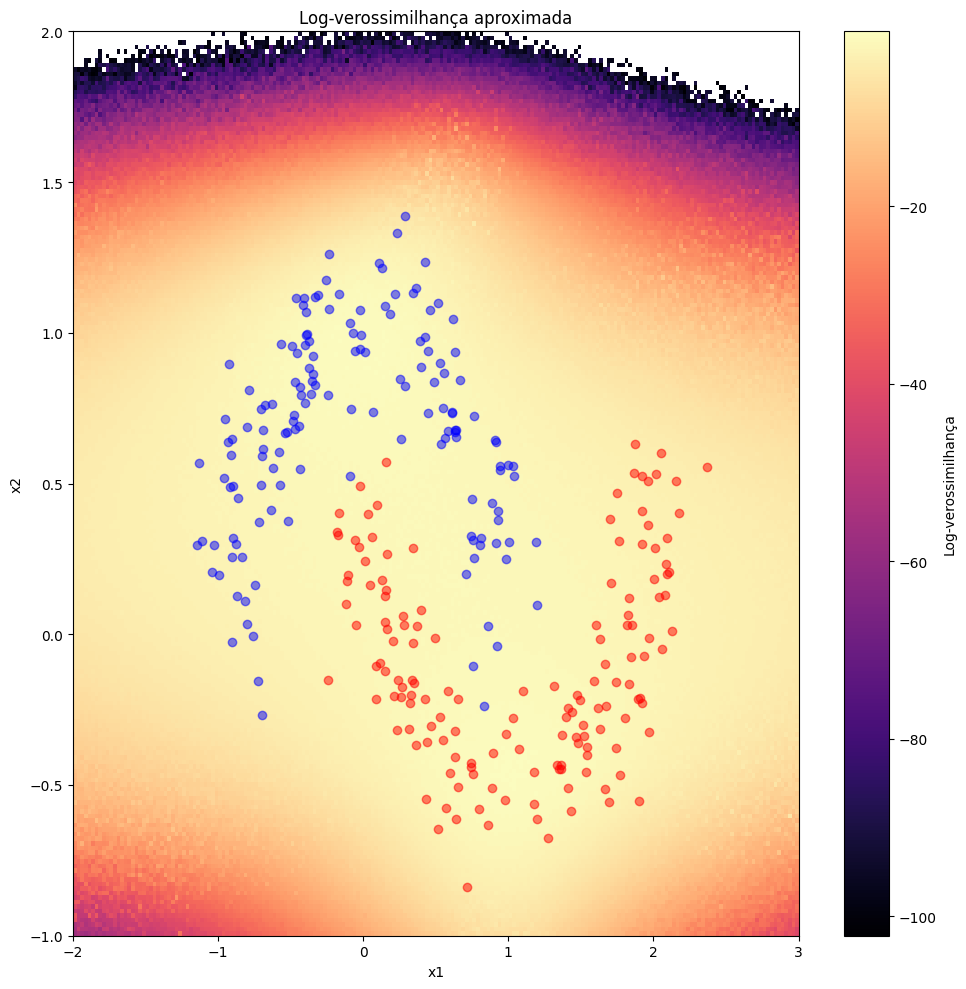

In [12]:
plot_log_marginal(model_VAE)